In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import riskfolio.Portfolio as pf
import riskfolio.PlotFunctions as plf
import matplotlib as plt
import riskfolio.Reports as rp

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import black_litterman, risk_models
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import EfficientFrontier, objective_functions

In [2]:
start = "2016-01-01"
end = "2020-12-30"

# Tickers of assets
assets = ['DGX', 'MMM', 'ABBV', 'LLY', 'MDT', 'MRK', 'CTLT', 'IQV']
assets.sort()

In [3]:
data = yf.download(assets, start = start, end = end, threads = False)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%***********************]  8 of 8 completed


In [4]:
Y = data[assets].pct_change().dropna()

In [5]:
S = risk_models.CovarianceShrinkage(data[assets]).ledoit_wolf()

In [6]:
port = pf.Portfolio(returns = Y)
port.assets_stats(method_mu= 'hist', method_cov= 'hist') 

In [7]:
model='BL' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' 
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = False 
rf = 0.05
l = 0 
points = 50

In [8]:
market_data = yf.download("^GSPC", start = start, end = end, threads = False)
market_data = market_data.loc[:,('Adj Close')]

[*********************100%***********************]  1 of 1 completed


In [9]:
delta = black_litterman.market_implied_risk_aversion(market_data)

In [10]:
mcaps = {}
for t in assets:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]

In [11]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)

In [12]:
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta, absolute_views={})

In [13]:
ret_bl = bl.bl_returns()
S_bl = bl.bl_cov()

ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.max_sharpe()
#ef.min_volatility()
#ef.portfolio_performance(verbose=visualize)
weights = ef.clean_weights()

weights = pd.Series(weights)
display(weights)

C:\Apps\Anaconda3\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:247: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


ABBV    0.19747
CTLT    0.07990
DGX     0.04776
IQV     0.11648
LLY     0.17606
MDT     0.13471
MMM     0.10532
MRK     0.14230
dtype: float64

In [14]:
W1 = pd.DataFrame(weights, index = assets, columns = ['Black Lit'])

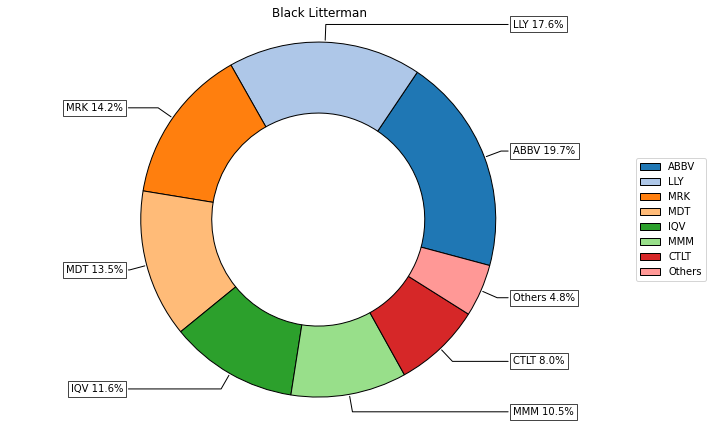

In [15]:
ax = plf.plot_pie(w=W1, title='Black Litterman', others=0.05, nrow = 25, cmap = "tab20", height=6, width=10, ax=None)

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)


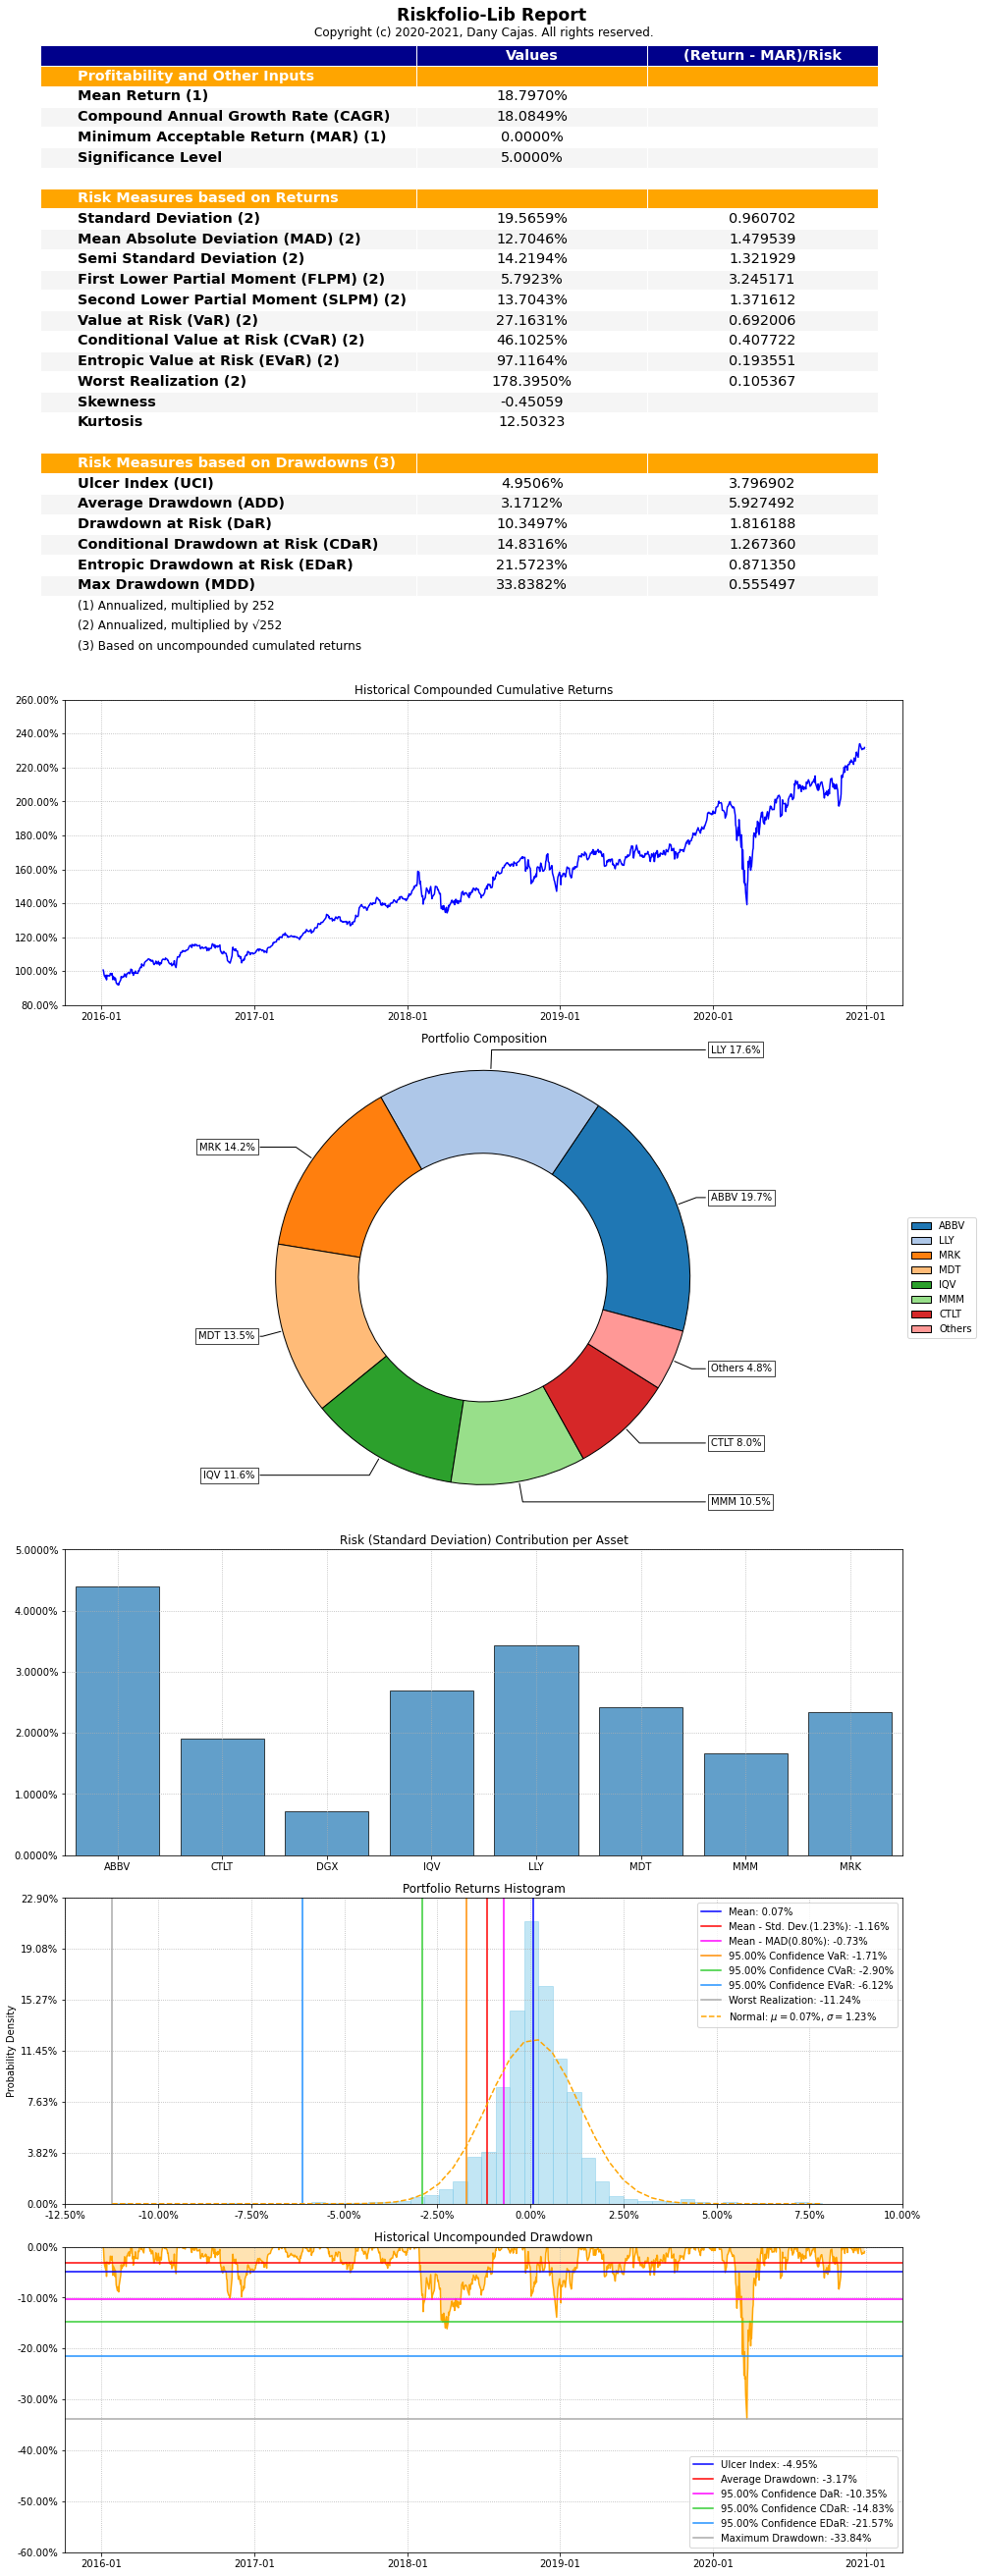

In [16]:
ax_report = rp.jupyter_report(Y, w=W1, rm='MV', rf=0, alpha=0.05, height=6, width=14,
                       others=0.05, nrow=25)